In [2]:
# !unzip faces94.zip
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [ ]:
#Problems 1-2
class NMFRecommender:

    def __init__(self, random_state=15,  rank=3, maxiter=200, tol=1e-3):
        """The parameter values for the algorithm"""
        self.random_state = random_state
        self.tol = tol
        self.maxiter = maxiter
        self.rank = rank
        
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""
        np.random.seed(self.random_state)
        self.W = np.random.random((m, self.rank))
        self.H = np.random.random((self.rank, n))
        return self.W, self.H
      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        #initialize matrices
        W, H = self.initialize_matrices(*V.shape) 
        r = np.zeros(self.maxiter * 2)

        for i in range(self.maxiter * 2):
            if i % 2 == 1:
                #set H as constraint
                H = cp.Variable(shape=H.shape, nonneg=True) 
                constraint = [H >= 0]

            #set W as constraint
            else:
                W = cp.Variable(shape=W.shape, nonneg=True)
                constraint = [W >= 0]
            
            #set up and solve problem
            obj = cp.Minimize(cp.norm(V - W*H, 'fro')) 
            prob = cp.Problem(obj, constraint)
            prob.solve()

            r[i] = prob.value

            if i % 2 == 1:
                H = H.value
                self.H = H
            else:
                W = W.value
                self.W = W

    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        #multiply W@
        return self.W @ self.H


In [ ]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )

    #create recommender
    rec = NMFRecommender(15, 2) 

    #initialize matrix
    rec.initialize_matrices(*V.shape)

    #solve/fit
    rec.fit(V)

    return np.round(rec.W, 2), np.round(rec.H, 2), np.sum(rec.H[1,:] > rec.H[0,:])

In [ ]:
prob3()

(array([[0.43, 1.56],
        [0.73, 2.67],
        [0.26, 1.23],
        [2.77, 0.  ],
        [0.  , 0.37]]), array([[0.  , 0.73, 1.08, 1.45, 0.35, 0.37],
        [0.59, 0.77, 0.07, 0.  , 0.8 , 0.77]]), 4)

In [5]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       
                # Make sure to only grab jpg and load the image, then convert to greyscale.
                #Flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break

    # Put all the face vectors as columns into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255

    #reshape image
    image = np.reshape(image,(m,n))
    
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


In [ ]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """

    #load faces
    faces = get_faces()
    alphas = [0, 0.2, 0.5]
    l1_ratios = [0, 10e-5, 10]

    plt.rcParams['figure.figsize'] = (10, 10)
    fig, ax = plt.subplots(3, 3)
    for i in range(3):
        for j in range(3):

            #fit for each combination
            model = NMF(75, alpha=alphas[i], l1_ratio=l1_ratios[j])
            W = model.fit_transform(faces)
            H = model.components_

            #reconstruct
            image = W @ H[:,2]

            #plot face
            image = image / 255
            image = np.reshape(image,(200,180))
            ax[i,j].imshow(image,cmap = "gray")
            ax[i,j].set_title("alpha: {}, l1_ratio: {}".format(alphas[i], l1_ratios[j]))
            

    plt.tight_layout()

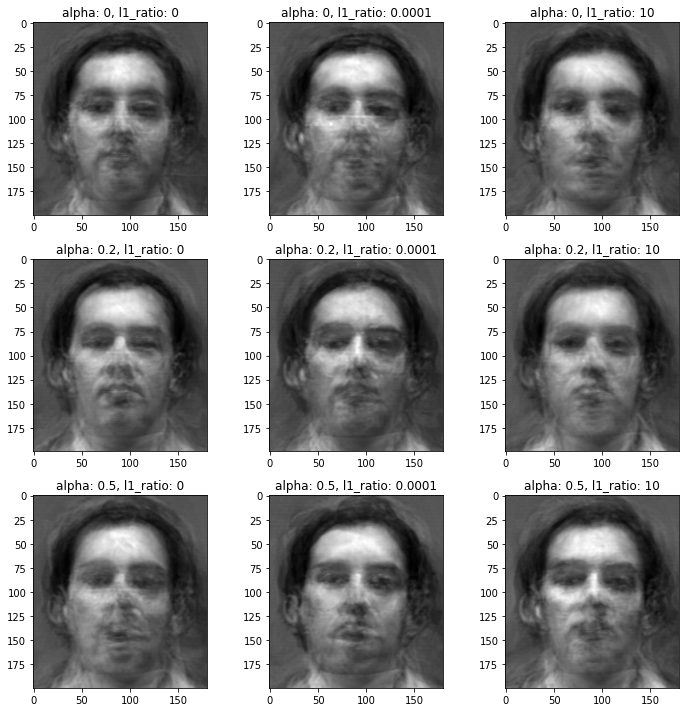

In [ ]:
prob4()

In [6]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    faces = get_faces()

    #get the best values
    model = NMF(75, alpha=0.5, l1_ratio=0) 

    #fit the model
    W = model.fit_transform(faces)
    H = model.components_

    #plot
    plt.rcParams['figure.figsize'] = (10, 70)
    fig, ax = plt.subplots(11, 2)

    #get basis faces for face 2
    sorted = np.argsort(H[:,1])[-10:]
    for j, b in enumerate(sorted):
        image = W[:,b] / 255
        image = np.reshape(image,(200,180))
        ax[j,0].imshow(image,cmap = "gray")
        ax[j,0].set_title("Face 2")
    
    #face 12
    sorted = np.argsort(H[:,11])[-10:]
    for j, b in enumerate(sorted):
        image = W[:,b] / 255
        image = np.reshape(image,(200,180))
        ax[j,1].imshow(image,cmap = "gray")
        ax[j,1].set_title("Face 12")
    
    image = faces[:, 1]
    image = np.reshape(image, (200, 180))
    ax[10, 0].imshow(image, cmap = "gray")
    ax[10, 0].set_title("Original Face 2")

    image = faces[:, 11]
    image = np.reshape(image, (200, 180))
    ax[10, 1].imshow(image, cmap = "gray")
    ax[10, 1].set_title("Original Face 12")
    
    plt.tight_layout()

In [7]:
prob5()